# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from src.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'src/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **src/classifiers/softmax.py**. 


In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from src.classifiers.softmax import softmax_loss_naive, softmax_loss_vectorized
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.000001
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.302234
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Initial W are small and random. That makes each training example equally likely to fall in any of the class label. And taking avarage across all training example loss even smoother. Hence, there are 10 classes and so loss = 0.1*


In [14]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from src.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.316979 analytic: -1.316979, relative error: 2.403712e-08
numerical: -0.841574 analytic: -0.841574, relative error: 4.205369e-09
numerical: -0.186114 analytic: -0.186114, relative error: 7.126681e-08
numerical: -4.088521 analytic: -4.088521, relative error: 2.525822e-08
numerical: 1.558252 analytic: 1.558252, relative error: 4.068486e-08
numerical: 1.396096 analytic: 1.396096, relative error: 4.420012e-08
numerical: 3.583178 analytic: 3.583178, relative error: 1.162099e-08
numerical: -0.064619 analytic: -0.064619, relative error: 1.351636e-07
numerical: 0.761643 analytic: 0.761643, relative error: 1.653009e-08
numerical: 0.117431 analytic: 0.117430, relative error: 2.746701e-07
numerical: 1.227968 analytic: 1.227968, relative error: 1.018034e-08
numerical: -2.215911 analytic: -2.215912, relative error: 4.422500e-08
numerical: 0.093753 analytic: 0.093753, relative error: 3.283811e-07
numerical: 3.218429 analytic: 3.218429, relative error: 9.843111e-09
numerical: -3.595382 a

In [16]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from src.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.302223e+00 computed in 0.156446s
vectorized loss: 2.302223e+00 computed in 0.005462s
Loss difference: 0.000000
Gradient difference: 0.000000


In [18]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from src.classifiers import Softmax

np.random.seed(0)
learning_rates = np.logspace(-4, -8, num=10)
regularization_strengths = np.logspace(5, -5, num=20)

results = {}
best_val = -1
best_softmax = None
best_lr = None
best_reg = None

################################################################################                                                                       #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

tic = time.time()
for lr_index, lr in enumerate(learning_rates):
    for reg_index, reg in enumerate(regularization_strengths):
                
        softmax = Softmax()
        loss_hist = softmax.train(
            X_train, 
            y_train, 
            learning_rate=lr, 
            reg=reg, 
            num_iters=100, 
            verbose=False
        )
        
        y_train_pred = softmax.predict(X_train)
        y_train_accuracy = np.mean(y_train == y_train_pred)
        
        y_val_pred = softmax.predict(X_val)
        y_val_accuracy = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (y_train_accuracy, y_val_accuracy)
        
        if best_val < y_val_accuracy:
            best_val = y_val_accuracy
            best_softmax = softmax
            best_lr = lr
            best_reg = reg
        
toc = time.time()
print 'Cross-validation procress took %fs' % (toc - tic)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val
print 'best learning rate: %e' % best_lr
print 'best lreg: %e' % best_reg

src/classifiers/softmax.py:83: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(num/den)


Cross-validation procress took 196.174022s
best validation accuracy achieved during cross-validation: 0.337000
best learning rate: 1.668101e-06
best lreg: 2.976351e+04


In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set

# Evaluate the best svm on test set
softmax = Softmax()
loss_hist = softmax.train(
    X_train, 
    y_train, 
    learning_rate=1.668101e-06, 
    reg=2.976351e+04, 
    num_iters=5000, 
    verbose=True
)

y_train_pred = softmax.predict(X_train)
train_accuracy = np.mean(y_train == y_train_pred)
print 'linear Softmax on raw pixels train set accuracy: %f' % train_accuracy

y_val_pred = softmax.predict(X_val)
val_accuracy = np.mean(y_val == y_val_pred)
print 'linear Softmax on raw pixels val set accuracy: %f' % val_accuracy

y_test_pred = softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear Softmax on raw pixels test set accuracy: %f' % test_accuracy

iteration 0 / 5000: loss 462.532537
iteration 100 / 5000: loss 2.106797
iteration 200 / 5000: loss 2.106295


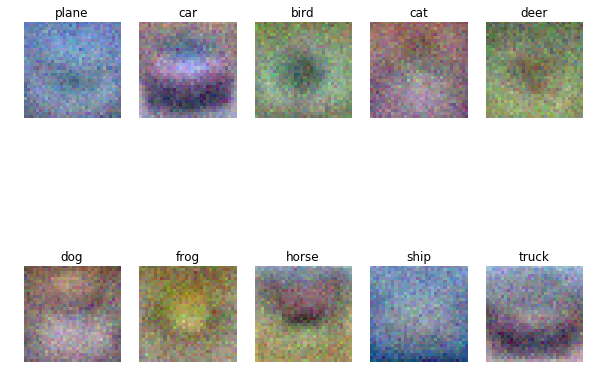

In [26]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])